#### dependencies

In [ ]:
!pip install EMD-signal
!pip install prophet
!pip install xlrd ==2.0.1
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
ERROR: Invalid requirement: '==2.0.1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.5 MB/s eta 0:00:00


In [ ]:
# !pip freeze > requirements.txt
# !pip uninstall -r requirements.txt -y

#### imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error , mean_squared_error, mean_absolute_error

In [ ]:
from PyEMD import EMD
from PyEMD import CEEMDAN
from prophet import Prophet
from pmdarima import auto_arima

# **2. Solar-2021**

In [ ]:
test_size = 12

## 2.0 Read data

In [ ]:
sol_df = pd.read_csv("/Datasets/solar-2021.csv")
sol_df.head()

,y
0,0.022
1,0.024
2,0.032
3,0.036
4,0.039


In [ ]:
sol_ds = pd.date_range(start="2005-01-01", periods = len(sol_df), freq="MS")
sol_df["ds"]= sol_ds

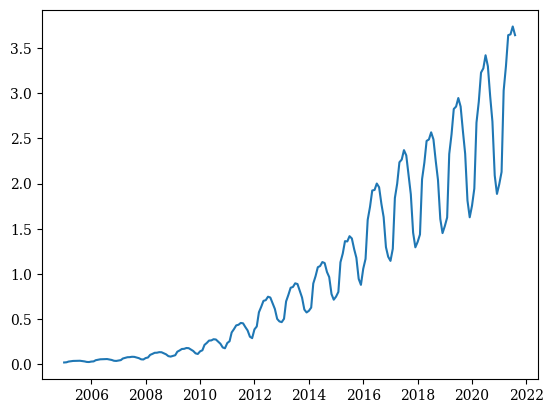

In [ ]:
plt.plot(sol_df.ds, sol_df.y)

In [ ]:
sol_df.shape

(200, 2)

In [ ]:
sol_train_set = sol_df[:-test_size]
sol_test_set = sol_df[-test_size:]

## 2.1 Prophet

In [ ]:
sol_prophet = Prophet(seasonality_mode="multiplicative")
sol_prophet.fit(sol_train_set)
sol_future = sol_prophet.make_future_dataframe(len(sol_test_set), freq="MS")
sol_forecast = sol_prophet.predict(sol_future)

## 2.2 EMD

### decomposition

In [ ]:
emd = EMD(spline_kind = 'akima')
sol_imfs = emd.emd(sol_train_set.y.values)
sol_imfs.shape

### +Prophet

In [ ]:
sol_forecast_temp=pd.DataFrame()
sol_forecast_temp["ds"] = sol_ds
sol_forecast_temp["yhat"] = 0

for imf in sol_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = sol_ds[:len(sol_train_set)]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="multiplicative")
  model.fit(temp)
  future = model.make_future_dataframe(test_size, freq="MS")
  sol_emd_forecast = model.predict(future)
  sol_forecast_temp["yhat"] += sol_emd_forecast['yhat']

## 2.3 CEEMDAN

### decomposition

In [ ]:
cemd = CEEMDAN(spline_kind = 'akima')
sol_c_imfs = cemd.ceemdan(sol_train_set.y.values)

In [ ]:
sol_c_imfs.shape

(4, 188)

### +Prophet

In [ ]:
sol_c_forecast_temp=pd.DataFrame()
sol_c_forecast_temp["ds"] = sol_ds
sol_c_forecast_temp["yhat"] = 0

for imf in sol_c_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = sol_ds[:len(sol_train_set)]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="multiplicative")
  model.fit(temp)
  future = model.make_future_dataframe(test_size, freq="MS")
  sol_cemd_forecast = model.predict(future)
  sol_c_forecast_temp["yhat"] += sol_cemd_forecast['yhat']

## 2.4 ICEEMDAN

### import

In [ ]:
solar2_ic_imfs = pd.read_csv("/ICEEMDAN-IMFS/IMF_solar2.csv", header = None)
solar2_ic_imfs = solar2_ic_imfs.to_numpy()
solar2_ic_imfs.shape

(4, 188)

### +Prophet

In [ ]:
sol2_ic_forecast_temp=pd.DataFrame()
sol2_ic_forecast_temp["ds"] = sol_ds
sol2_ic_forecast_temp["yhat"] = 0

for imf in solar2_ic_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = sol_ds[:len(sol_train_set)]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="multiplicative")
  model.fit(temp)
  future = model.make_future_dataframe(test_size, freq="MS")
  sol2_icemd_forecast = model.predict(future)
  sol2_ic_forecast_temp["yhat"] += sol2_icemd_forecast['yhat']

## 2.5 SARIMAX

In [ ]:
temp = sol_train_set.copy()
temp.index = sol_train_set.ds
temp.drop("ds", axis=1,inplace=True)
temp

In [ ]:
sol_model_arima = auto_arima(temp, stationary=True)
sol_forecast_arima = sol_model_arima.predict(len(sol_test_set))

In [ ]:
sol_model_arima.summary()

# plots

### test set chart

In [ ]:
def plotting_test(df, df_p, df_ep, df_cp, df_icp, df_s, ylabel, xlabel, name, test_size):
  fig, ax = plt.subplots(layout="constrained", figsize=(12,7))
  plt.rcParams['font.family'] = 'serif'
  plt.rcParams['font.serif'] += ['Times New Roman']

  width = 3
  msize = 9

  ax.plot(df.ds[-test_size:], df.y[-test_size:], label = "Original",color ='black', marker = 'o', ms= msize-2, lw=width, mfc = 'white', zorder=10, alpha=0.9)
  ax.plot(df_p.ds[-test_size:], df_p.yhat[-test_size:], label = "Prophet", marker = 'X', ms = msize+1, lw=width, mfc='white')
  ax.plot(df_ep.ds[-test_size:], df_ep.yhat[-test_size:], label = "Prophet-EMD", marker = '^', markersize = msize, lw=width,  mfc = 'white')
  ax.plot(df_cp.ds[-test_size:], df_cp.yhat[-test_size:], label = "Prophet-CEEMDAN", marker = 'h', ms = msize+1, lw=width, mfc='white')
  ax.plot(df_icp.ds[-test_size:], df_icp.yhat[-test_size:], label = "Prophet-ICEEMDAN", marker = 'P', ms = msize, lw=width, mfc='white' , alpha=1)
  ax.plot(df_cp.ds[-test_size:], df_s,  label = "SARIMAX", marker='v', ms=msize+1, lw=width, mfc='white')

  plt.margins(0.05,0.5)
  ax.legend(fontsize = 15, loc='upper left')
  plt.grid(axis='y')
  plt.ylabel(ylabel, fontsize=17, labelpad=15, fontfamily= "serif", fontweight="bold")
  plt.xlabel(xlabel, fontsize=17, labelpad=10, fontfamily= "serif", fontweight="bold")
  ceil = ax.get_ylim()
  plt.ylim(ceil[0], ceil[1]+(0.05*ceil[1]))

  plt.xticks(df.ds[-test_size:], rotation = 30, fontweight="bold", fontsize = 13)
  plt.yticks(fontweight='bold', fontsize = 13)

  plt.savefig(name, dpi=1200)


#### reading data

In [ ]:
sol_test = 12
sol_df = pd.read_csv("/Datasets/solar-2021.csv")
sol_ds = pd.date_range(start="2005-01-01", periods = len(sol_df), freq="MS")
sol_df["ds"]= sol_ds

In [ ]:
sol_df_p = pd.read_excel("/Forecasts/solar-2021/sol2_Prophet.xlsx")
sol_df_p = sol_df_p[['ds', 'yhat']]

In [ ]:
sol_df_ep = pd.read_excel("/Forecasts/solar-2021/sol2_prophet_EMD.xlsx")
sol_df_ep = sol_df_ep[['ds', 'yhat']]

In [ ]:
sol_df_cp = pd.read_excel("/Forecasts/solar-2021/sol2_prophet_CEEMDAN.xlsx")
sol_df_cp = sol_df_cp[['ds', 'yhat']]

In [ ]:
sol_df_icp = pd.read_excel("/Forecasts/solar-2021/sol2_prophet_iceemdan.xlsx")
sol_df_icp = sol_df_icp[['ds', 'yhat']]

In [ ]:
sol_df_s = pd.read_excel("/Forecasts/solar-2021/sol2_SARIMAX.xlsx")
sol_df_s = sol_df_s[0]
sol_df_s.columns=['yhat']

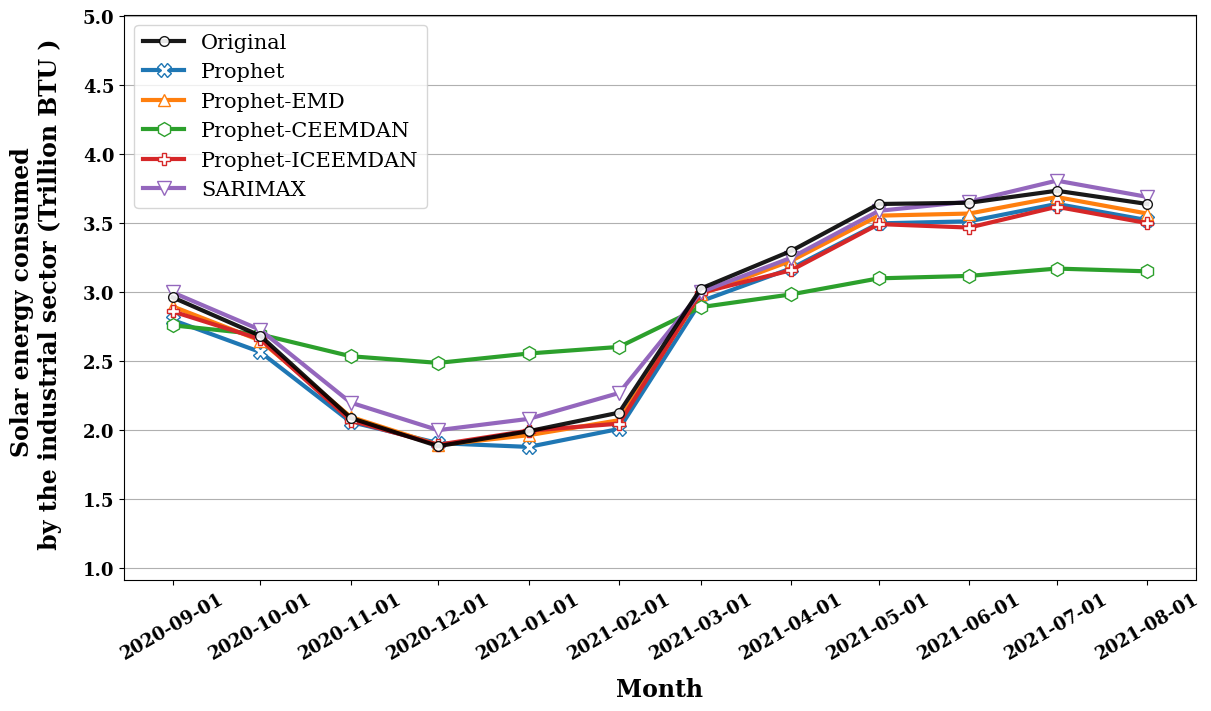

In [ ]:
plotting_test(sol_df, sol_df_p, sol_df_ep, sol_df_cp, sol_df_icp, sol_df_s, "Solar energy consumed \n by the industrial sector (Trillion BTU )", "Month", "solar21_test_func.jpg", test_size)

### bar plot

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] += ['Times Roman']
width = 0.1

def bar_plotter(values, title, name, tick):
  xticks = ['MAPE']
  multiplier = 0
  x = np.arange(len(xticks))

  fig, ax = plt.subplots(layout="constrained", figsize=(10,6))

  for i,j in values.items():
    offset = width * multiplier
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] += ['Times Roman']
    rects = ax.bar(x + offset, j, width, label = i)
    ax.bar_label(rects, padding=4, fontweight="bold", fontsize=13)
    multiplier+=1

  plt.legend(fontsize=13, loc="upper left")

  ax.set_xticks(x+tick, xticks, fontsize=14, fontweight="bold")
  plt.yticks(fontweight='bold', fontsize=14)

  ceil = round(max(list(values.values())) + 0.2*(max(list(values.values()))))

  plt.ylim(0, ceil)

  plt.grid(axis='y')
  ax.set_axisbelow(True)
  plt.margins(2*(1-len(values)/10), 0)
  plt.savefig(f"{name}.jpg", dpi=1200)

round


In [ ]:
def rounder(dictionary):
  for i,j in dictionary.items():
    dictionary[i] = round(j, 2)
  return(dictionary)

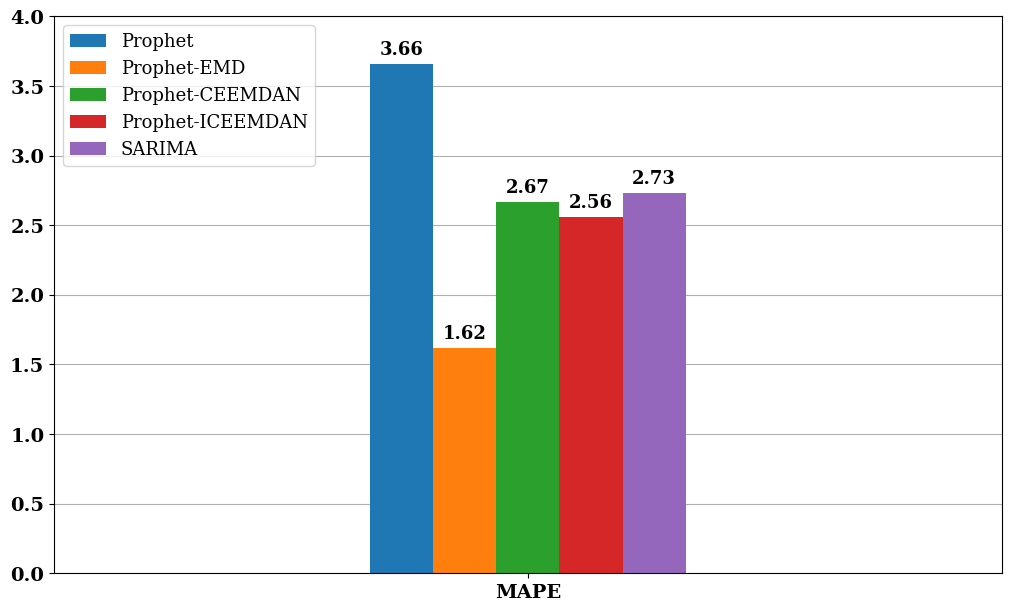

In [ ]:
sol21_values = {
    # method : (MAPE)
    "Prophet":(3.659),
    "Prophet-EMD": (1.622),
    "Prophet-CEEMDAN":(2.67),
    "Prophet-ICEEMDAN":(2.56),
    "SARIMA":(2.731),
}

bar_plotter(rounder(sol21_values), "Solar energy consumption evaluation 2", "Solar2021_comparison_bar", 0.2)